# Recursive Matrix Multiplication
### Set values for whether you would like to generate new results or just use the JSON that has previously been generated

In [1]:
# Set to true if you want to run the tests again. Otherwise just loads results from JSON
GENERATE_NEW_RESULTS = False

# Set to true if you want to save figures to disk. Change path as needed
SAVE_FIGURES_TO_DISK = False
FIG_SAVE_PATH = "../thesis/figures"

Load in packages and set options for prettier plots

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import numpy as np
import concurrent.futures
import json

from test_results_helper_funcs import save_fig, make_cache, MORTON, ROW_ARR, BLOCK_ARR, SIM_CACHE_TIMES

from data_structures.morton_order import MortonOrder
from data_structures.block_array import BlockArray
from data_structures.row_major_array import RowMajorArray

from algorithms.matmul import matmul_rec

In [3]:
matplotlib.rcParams['figure.figsize'] = (9.0, 4.8)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

## Defining functions/variables to run tests

In [4]:
def results_for_arr_and_tile_size(vals):
    n, tile_size = vals
    r = int(np.log2(n)) - int(np.log2(tile_size))
    if r <= 0:
        return None, tile_size

    print(f"{n} -- {tile_size}")
    
    cs1 = make_cache()
    cs2 = make_cache()

    rnd_vals1 = np.random.rand(n, n)
    rnd_vals2 = np.random.rand(n, n)

    morton1 = MortonOrder(rnd_vals1, cache=cs1)
    morton2 = MortonOrder(rnd_vals2, cache=cs1, offset=morton1.get_next_offset())

    row_arr1 = RowMajorArray(rnd_vals1, cache=cs2)
    row_arr2 = RowMajorArray(rnd_vals2, cache=cs2, offset=row_arr1.get_next_offset())

    # Warm up
    matmul_rec(morton1, morton2, r)
    matmul_rec(row_arr1, row_arr2, r)

    # Reset caches
    cs1.force_write_back()
    cs1.reset_stats()
    cs2.force_write_back()
    cs2.reset_stats()

    # Do actual test
    matmul_rec(morton1, morton2, r)
    matmul_rec(row_arr1, row_arr2, r)
    
    # Save results
    obj = {}
    obj[MORTON] = list(cs1.stats())
    obj[ROW_ARR] = list(cs2.stats())

    print(f"{n} -- {tile_size} finished")
    return obj, tile_size
    

def results_for_arr_size(n):
    print(n)
    vals = [(n, tile_size) for tile_size in tile_sizes]    
    obj = {}
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for (res, tile_size) in executor.map(results_for_arr_and_tile_size, vals):
            if res is not None:
                obj[tile_size] = res
    return obj, n

In [5]:
ns = [2**i for i in range(5, 9)]
tile_sizes = [2**i for i in range(2, 8)]

print(ns)
print(tile_sizes)

[32, 64, 128, 256]
[4, 8, 16, 32, 64, 128]


## Generating/loading in test results

In [6]:
if GENERATE_NEW_RESULTS:
    results = {}
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for (obj, n) in executor.map(results_for_arr_size, ns):
            results[str(n)] = obj
            
    with open('results/matrix-result.json', 'w') as f:
        json.dump(results, f, indent=4)
else:
    with open('results/matrix-result.json', 'r') as f:
        results = json.load(f)

## Plotting

In [7]:
def get_val_arr(n, cache_level=0, stat="HIT_count"):    
    res_arr = []
    n = str(n)
    for tile_size in results[n]:
        val_morton = results[n][tile_size][MORTON][cache_level][stat]
        val_arr = results[n][tile_size][ROW_ARR][cache_level][stat]
        res_arr.append(
            np.nan if val_arr == 0 else float(val_morton) / float(val_arr)
        )
    return res_arr

In [8]:
def make_plot(cache_level=0, stat="HIT_count"):
    labels = tile_sizes
    n32 = get_val_arr(32, stat=stat)
    n64 = get_val_arr(64, stat=stat)
    n128 = get_val_arr(128, stat=stat)
    n256 = get_val_arr(256, stat=stat)

    x = np.arange(len(labels))  # the label locations
    width = 0.20  # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(x[:len(n32)] - 1.5*width, n32, width, label='$n=32$')
    ax.bar(x[:len(n64)] - 0.5*width, n64, width, label='$n=64$')
    ax.bar(x[:len(n128)] + 0.5*width, n128, width, label='$n=128$')
    ax.bar(x[:len(n256)] + 1.5*width, n256, width, label='$n=256$')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(f'Relative {stat}')
    ax.set_xlabel('Tile size')
    ax.set_title(f'Relative {stat} of Morton Order vs. RowMajorArray')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    save_fig(f"relative-{stat}-matrix-l{cache_level}.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)

    plt.show()

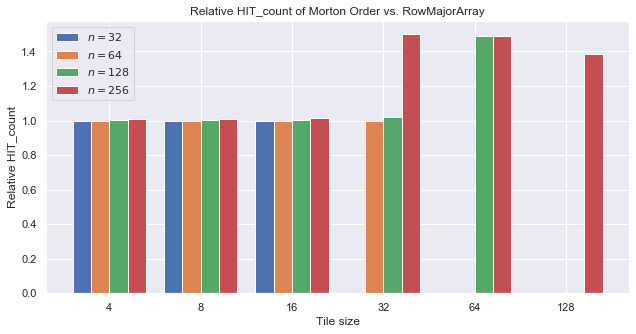

In [9]:
make_plot()

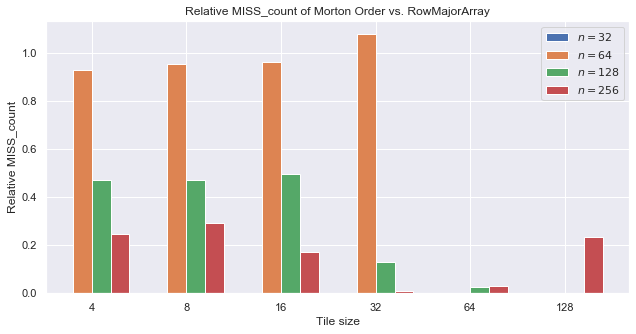

In [10]:
make_plot(stat="MISS_count")

Sanity check:

In [11]:
morton_total = results['256']['8'][MORTON][0]["HIT_count"] + results['256']['8'][MORTON][0]["MISS_count"]
row_arr_total = results['256']['8'][ROW_ARR][0]["HIT_count"] + results['256']['8'][ROW_ARR][0]["MISS_count"]
print(morton_total == row_arr_total)

True


In [12]:
print("Morton hit: ", results['256']['8'][MORTON][0]["HIT_count"])
print("RowArr hit: ", results['256']['8'][ROW_ARR][0]["HIT_count"])
print("Morton miss:", results['256']['8'][MORTON][0]["MISS_count"])
print("RowArr miss:", results['256']['8'][ROW_ARR][0]["MISS_count"])

Morton hit:  50178752
RowArr hit:  49808128
Morton miss: 152896
RowArr miss: 523520


## Simulated time

In [51]:
def get_val_arr_time(n):
    res_arr = []
    n = str(n)
    for tile_size in results[n]:
        morton_time = 0.0
        row_arr_time = 0.0
        for cache_level in [0, 1, 2, 3]:
            for typ in ['HIT', 'MISS']:
                morton_count = results[n][tile_size][MORTON][cache_level][f"{typ}_count"]
                morton_time += morton_count * SIM_CACHE_TIMES[cache_level][typ]
                row_arr_count = results[n][tile_size][ROW_ARR][cache_level][f"{typ}_count"]
                row_arr_time += row_arr_count * SIM_CACHE_TIMES[cache_level][typ]
        res_arr.append(morton_time / row_arr_time)
    return res_arr

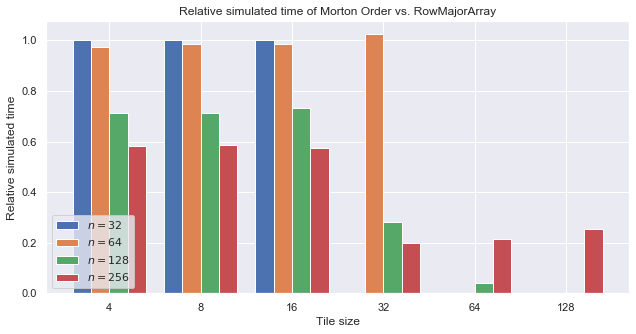

In [54]:
labels = tile_sizes
n32 = get_val_arr_time(32)
n64 = get_val_arr_time(64)
n128 = get_val_arr_time(128)
n256 = get_val_arr_time(256)

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x[:len(n32)] - 1.5*width, n32, width, label='$n=32$')
ax.bar(x[:len(n64)] - 0.5*width, n64, width, label='$n=64$')
ax.bar(x[:len(n128)] + 0.5*width, n128, width, label='$n=128$')
ax.bar(x[:len(n256)] + 1.5*width, n256, width, label='$n=256$')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Relative simulated time')
ax.set_xlabel('Tile size')
ax.set_title('Relative simulated time of Morton Order vs. RowMajorArray')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=3)

fig.tight_layout()

save_fig("relative-simulated-time-matrix.pdf", FIG_SAVE_PATH, SAVE_FIGURES_TO_DISK)

plt.show()